In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option('display.max_rows', None)

figures_path = './figures/'

# Fonctions Utiles

In [2]:
def get_dataframe_info(df, ascending=False, percentage=False):
    """
    Return 
    Parameters :
      - df : Pandas dataframe  
      - ascending : Bool 
    output
      df_null_counts -> DataFrame Info (sorted)
    """
    column_names = ['Column', 'Dtype', 'Non-null Count']
    df_types = pd.DataFrame(df.dtypes)
    df_nulls = df.count() 
    if percentage : 
        df_nulls *= 100.0 / df.shape[0]
        column_names[-1] += ' (%)'
    
    df_null_count = pd.concat([df_types, df_nulls], axis=1)
    df_null_count = df_null_count.reset_index()
    
    # Reassign column names
    
    df_null_count.columns = column_names

    # Add this to sort
    df_null_count = df_null_count.sort_values(by=column_names[-1], ascending=ascending)
    
    return df_null_count

def astype_inplace(df, **kwargs):
    for col, dtype in kwargs.items():
        df.loc[:,col] = df[col].astype(dtype)

def outliers_thresold(df, columns):

    Q1 = df[columns].apply(lambda x : x.quantile(q=0.25), axis=0)
    Q3 = df[columns].apply(lambda x : x.quantile(q=0.75), axis=0)
    Q2 = df[columns].apply(lambda x : x.quantile(q=0.50), axis=0)

    IQR = Q3 - Q1
    threshold = Q2 + 1.5*IQR 

    return pd.DataFrame(threshold).transpose()

# Chargement des Données

In [3]:
# Chemin du CSV
file = 'fr.openfoodfacts.org.products.csv'

In [4]:
 # Séparateur utilisé dans le fichier CSV
delim='\t'

# Chargement du CSV dans un DataFrame Pandas
df = pd.read_csv(file, delimiter=delim, low_memory=False)

In [5]:
# Affiche la taille du data frame
nb_rows, nb_cols = df.shape
print(f"Le CSV contient {nb_cols} colones et {nb_rows} lignes.")

Le CSV contient 162 colones et 320772 lignes.


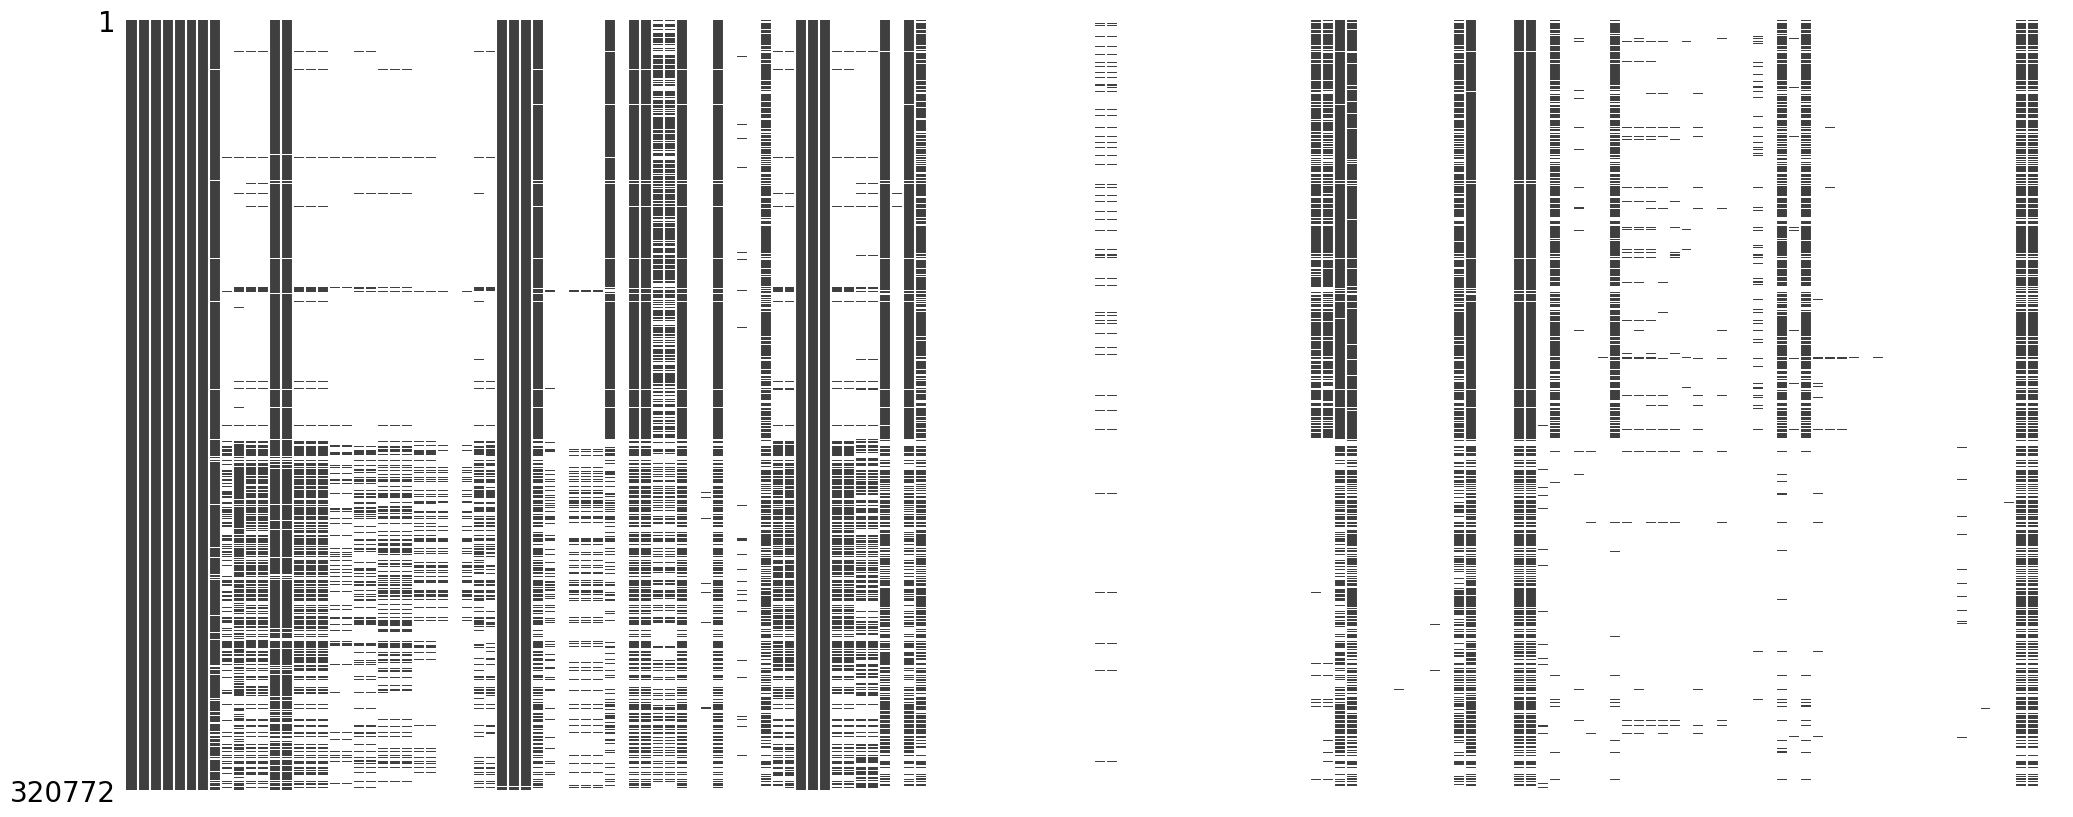

In [6]:
# Visualisation du taux de remplissage
fig = msno.matrix(df, sparkline=False)
fig_copy = fig.get_figure()
fig_copy.savefig(figures_path + 'raw_matrix_plot.png', bbox_inches = 'tight')

In [7]:
# Affiche les Dtypes et taux remplissage de chque colonnes
df_info = get_dataframe_info(df, ascending=False, percentage=True)
df_info

,Column,Dtype,Non-null Count (%)
6,last_modified_datetime,object,100.000000
5,last_modified_t,object,100.000000
2,creator,object,99.999377
3,created_t,object,99.999065
4,created_datetime,object,99.997194
0,code,object,99.992830
1,url,object,99.992830
56,states,object,99.985660
58,states_fr,object,99.985660
57,states_tags,object,99.985660


Beaucoup de colonnes sont vides. Pour réduire les données on peut enlever les colonnes dont le taux de remplissage et trop faible. D'après les métadonnées, la colonne code identifie de manière unique les produits. Or cette colonnes contient quelques valeurs manquantes.

In [8]:
# Suppression des lignes ayant un code manquant

df.dropna(subset=['code'], inplace=True)
df.reset_index(inplace=True, drop=True)

# Affiche la taille du data frame
nb_rows, nb_cols = df.shape
print(f"Le CSV contient {nb_cols} colones et {nb_rows} lignes.")

Le CSV contient 162 colones et 320749 lignes.


## Suppression des colonnes 

In [9]:
# Taux de remplissage seuil
filling_rate_threshold  = 3.5

columns_to_drop = df_info[df_info['Non-null Count (%)'] < filling_rate_threshold]['Column']
df.drop(columns=columns_to_drop, inplace=True)

# Affiche la taille du data frame
nb_rows, nb_cols = df.shape
print(f"Le DataFrame contient {nb_cols} colones et {nb_rows} lignes.")

Le DataFrame contient 77 colones et 320749 lignes.


## Conversion type des colonnes

In [10]:
# Object -> int64
df['created_t']       = df['created_t'].apply(pd.to_numeric)
df['last_modified_t'] = df['last_modified_t'].apply(pd.to_numeric)

In [11]:
# Object -> datetime64[ns] 
df['created_datetime']       = pd.to_datetime(df['created_datetime']      , format='%Y-%m-%dT%H:%M:%SZ')
df['last_modified_datetime'] = pd.to_datetime(df['last_modified_datetime'], format='%Y-%m-%dT%H:%M:%SZ')

In [12]:
df_info = get_dataframe_info(df, ascending=False, percentage=True)
df_info

,Column,Dtype,Non-null Count (%)
0,code,object,100.000000
1,url,object,100.000000
3,created_t,int64,100.000000
6,last_modified_datetime,datetime64[ns],100.000000
5,last_modified_t,int64,100.000000
4,created_datetime,datetime64[ns],99.999688
2,creator,object,99.999376
49,states,object,99.992829
51,states_fr,object,99.992829
50,states_tags,object,99.992829


Il manque des date created_datetime. Regardons si le time stamp qui leur est associé est valide.

In [13]:
df.loc[df['created_datetime'].isna()]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,vitamin-pp_100g,potassium_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
187478,3017760038409,http://world-fr.openfoodfacts.org/produit/3017...,marianne,0,NaT,1488992055,2017-03-08 16:54:15,Lulu la barquette (Fraise),Génoise garnie à la purée de fraise,120 g,...,0.08,0.031496,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0


Les deux colonnes created_t et created_datetime sont invalides. On les remplace par les valeur last_modified_t et last_modified_datetime.

In [14]:
rows_idx = df['created_datetime'].isna()

df.loc[rows_idx, 'created_t']        = df[rows_idx]['last_modified_t']
df.loc[rows_idx, 'created_datetime'] = df[rows_idx]['last_modified_datetime']

On vérifie que les timestamps correspondent aux datetime

In [15]:
(pd.to_datetime(df['created_t'], unit='s') == df['created_datetime']).value_counts()

True    320749
Name: count, dtype: int64

In [16]:
(pd.to_datetime(df['last_modified_t'], unit='s') == df['last_modified_datetime']).value_counts()

True    320749
Name: count, dtype: int64

On vérifie que les dates de création sont inférieures aux dates de dernières modifications

In [17]:
(df['created_t'] <= df['last_modified_t']).value_counts()

True    320749
Name: count, dtype: int64

On drop les colonnes created_t et last_modified_t

In [18]:
df.drop(columns=['created_t', 'last_modified_t'], inplace=True)

On tri les données par rapport à la date de création

In [19]:
df.sort_values(by='created_datetime', inplace=True)
df.reset_index(inplace=True, drop=True)

# Question 20

Les contributions au cours du temps

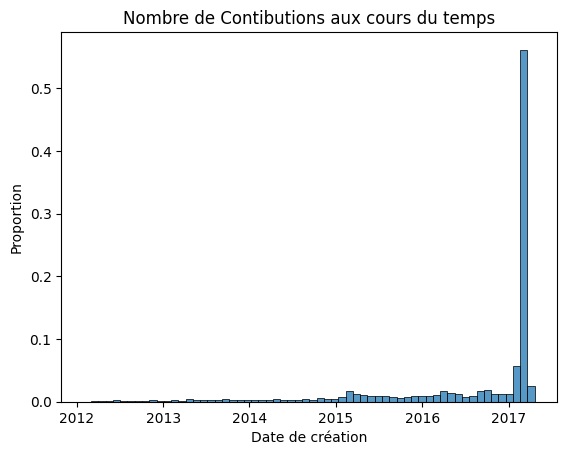

In [20]:
starting_date = df.loc[0, 'created_datetime']
ending_date   = df.loc[df.shape[0]-1, 'created_datetime']


bins = pd.date_range(start=starting_date,end=ending_date,freq='ME')
fig, ax = plt.subplots()
sns.histplot(df, x='created_datetime', stat='proportion', bins=len(bins))
plt.title('Nombre de Contibutions aux cours du temps')
plt.xlabel('Date de création')
plt.ylabel('Proportion')
fig.savefig(figures_path +'contributions_vs_temps.png', bbox_inches = 'tight')

Le nombre de contributions a commencer à être significatif vers 2015 et est resté stable jusque fin 2016. Début 2017 un import massif de produits semble avoir eu lieu.

# Question 16
Regardons les pays les plus contributeurs.

In [21]:
splitted_countries = df['countries'].dropna().str.split(',', expand=True).fillna('')
splitted_countries = splitted_countries.replace(to_replace=r'^en:FR$', value='France', regex=True)
splitted_countries = splitted_countries.apply(lambda x: x.str.upper().str.strip())


countries = splitted_countries.loc[:,0].value_counts().reset_index()

countries.columns = ['Country', 'Count']

count_threshold = 3000
countries = countries[countries['Count'] > count_threshold]

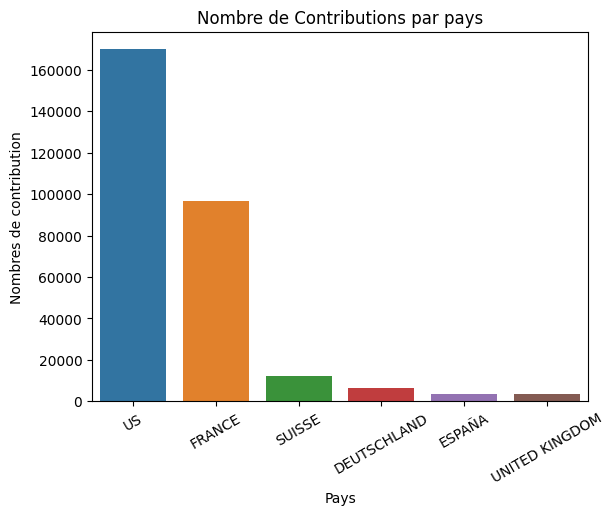

In [22]:
fig, ax = plt.subplots()
sns.barplot(countries, x='Country', y='Count', hue='Country')
plt.xlabel('Pays')
plt.ylabel('Nombres de contribution')
plt.xticks(rotation=30)
plt.title('Nombre de Contributions par pays')
fig.savefig(figures_path+'pays_contributeurs.png', bbox_inches = 'tight')

Bien qu'Open Food Facts soit un projet d'origine française. Le pays qui a contribué en majeure partie au jeu de données est les États-Unis.
# Question 17
Puisque deux pays prossède plus de la moitié du nombre de contributions, notre jeu de données contient beaucoup de biais géographiques.

# Question 18
Regardons les différents labels

In [23]:
tags = {}
df['labels_tags'] = df['labels_tags'].replace(to_replace=r'\w\w:|eu-', value='', regex=True)
for x in df['labels_tags'].str.split(','):
    if isinstance(x, float) : continue 
    for label in set(x):
        if len(label) > 3:
            try :
                tags[label][0] += 1
            except KeyError :
                tags[label] = [1]

df_tags = pd.DataFrame.from_dict(tags).transpose().reset_index()
df_tags.columns = ['Label', 'Count']

df_tags.sort_values(by='Count', inplace=True, ascending=False)
df_tags.reset_index(drop=True, inplace=True)

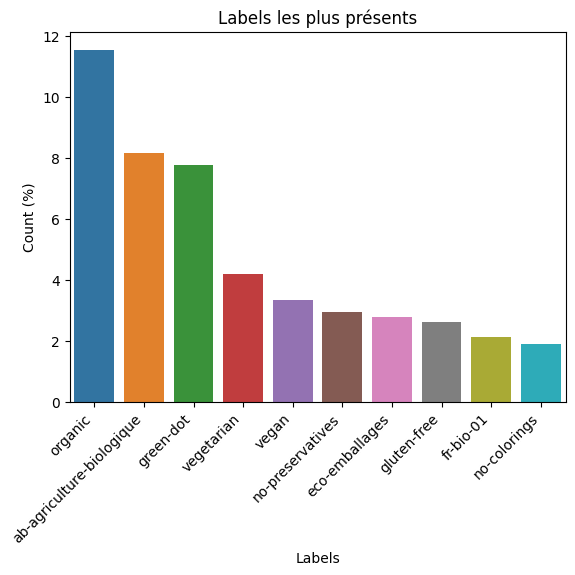

In [24]:
fig, ax = plt.subplots()
l_thr = 2000
sns.barplot(df_tags[df_tags['Count'] > l_thr], x='Label', y='Count', hue='Label', estimator=lambda x: 100*sum(x)/df_tags['Count'].sum())
plt.title('Labels les plus présents')

plt.ylabel('Count (%)')
plt.xlabel('Labels')
plt.xticks(rotation=45, ha='right')

fig.savefig(figures_path + 'labels.png', bbox_inches = 'tight')

On remarque que les labels les plus présents sont le *gree-dot* et le label *organic*. Bien que le label *organic* soit associé à certaines qualités nutritionnelles, le *green-dot* est lui associé au recyclage des emballages.

In [25]:
label_list = df_tags.loc[df_tags['Count'] > l_thr, 'Label'].tolist()

hash_labels_grades = {'label': [], 'grade' : [], 'count' : []}#{'nutrition-grade' : [,"c","d","e"]}
df_lg = pd.DataFrame(hash_labels_grades)
scores =  ['a', 'b',"c","d","e"]
df_lg = pd.DataFrame(hash_labels_grades)
for l in label_list :
    count = df[df['labels_tags'].str.contains(l) == True].groupby(['nutrition_grade_fr']).count()['labels_tags'].to_numpy(dtype=np.float64)
    #count /= count.sum()
    for i in range(5):
        df_lg = pd.concat([df_lg, pd.DataFrame({'label': [l], 'grade' : [scores[i]], 'count' : [count[i]]})])
    hash_labels_grades[l] = count.tolist()

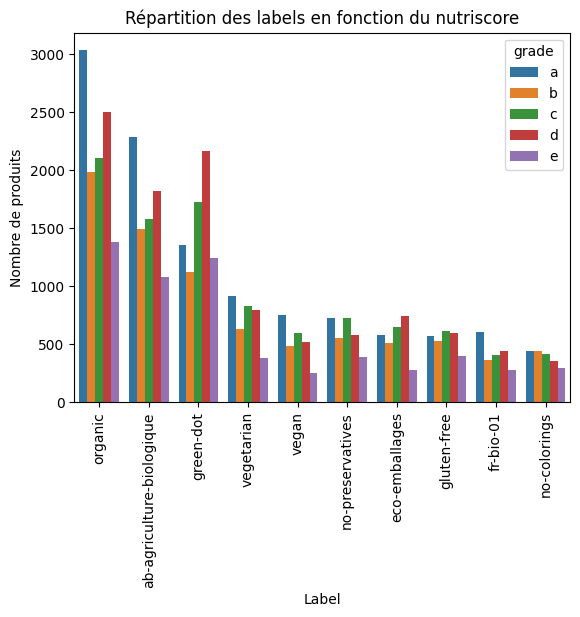

In [26]:
fig, ax = plt.subplots()

sns.barplot(df_lg, x ='label', y='count', hue='grade')
plt.title('Répartition des labels en fonction du nutriscore')

plt.xlabel('Label')
plt.ylabel('Nombre de produits')
plt.xticks(rotation=90, ha='center')

fig.savefig(figures_path + 'labels_vs_nutriscore.png', bbox_inches = 'tight')

On constate que leslabels associés au qualités nutritionnelles des aliments sont le plus souvent présents pour des aliments ayant un très bon score nutritionnel. En revanche, les labels concernant l'écologie/le recyclage sont d'avantage associé aux produits ayant un mauvais nutriscore.

# Question 19
Regardons les contributeurs les plus importants ainsi que leur taux de remplissage associé

In [27]:
df_creator = df['creator'].value_counts().reset_index()

thr_c = 1000
df_creator = df_creator[df_creator['count'] > thr_c]

for c in df_creator['creator']:
    c_idx = df_creator['creator'] == c
    creator_idx = df['creator'] == c
    df_creator.loc[c_idx,'filling_rate'] = df[creator_idx].count(axis=1).reset_index(drop=True).mean()/df.shape[1]

In [28]:
df_creator.head(10)

,creator,count,filling_rate
0,usda-ndb-import,169868,0.502122
1,openfoodfacts-contributors,40117,0.394872
2,kiliweb,13891,0.356847
3,date-limite-app,11918,0.265010
4,openfood-ch-import,11478,0.348946
5,tacite,7214,0.653404
6,sebleouf,5864,0.640455
7,tacinte,4398,0.457726
8,javichu,2768,0.687746
9,stephane,2691,0.520263


On voit que les contributeurs les plus importants sont soit des imports de base de données ou des projets d'applications. Regardons quand on été réalisé les import de la base *usda-ndb-import*

In [29]:
df_usda_ndb_import = df[df['creator'] == 'usda-ndb-import']

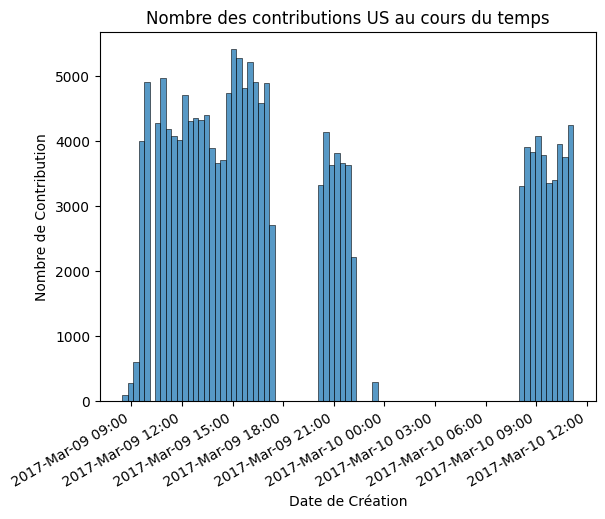

In [30]:
myFmt = mdates.DateFormatter('%Y-%b-%d %H:%M')

fig, ax = plt.subplots()
sns.histplot(df_usda_ndb_import, x='created_datetime')
ax.xaxis.set_major_formatter(myFmt)

plt.title('Nombre des contributions US au cours du temps')
plt.xlabel('Date de Création')
plt.ylabel('Nombre de Contribution')
plt.xticks(rotation=30, ha='right')

fig.savefig(figures_path + 'contributionUS_vs_temps.png', bbox_inches = 'tight')

La majorité de importations US correspond au pic de contributions depuis 2017

# Question 1

Pour évaluer si un aliment est sain, plusieurs critères clés doivent être pris en compte. Tout d'abord, les informations nutritionnelles, synthétisées par le Nutri-Score, nous renseignent sur la densité énergétique, la répartition des macronutriments (protéines, glucides, lipides), ainsi que sur les éléments à surveiller comme les graisses saturées, les sucres ajoutés et le sel. Le Nutri-Score, qui va de A à E, facilite la compréhension de ces informations pour le consommateur.
La liste des ingrédients constitue également une source précieuse d'information. Organisée par ordre décroissant de quantité, elle permet d'identifier rapidement la composition de l'aliment. Une liste courte avec des ingrédients reconnaissables est généralement préférable. Il convient d'être vigilant lorsque le sucre ou le sel apparaissent parmi les premiers ingrédients, et de privilégier les ingrédients complets plutôt que raffinés.
Les additifs alimentaires, reconnaissables à leur code "E" suivi d'un numéro, méritent une attention particulière. Bien que certains soient sans danger, d'autres sont controversés pour leurs effets potentiels sur la santé, notamment certains colorants artificiels, édulcorants et conservateurs comme les nitrites.
Le degré de transformation d'un aliment est également déterminant. Les aliments ultra-transformés, qui contiennent souvent de nombreux ingrédients industriels, sont généralement considérés comme moins sains que les aliments bruts ou peu transformés. Enfin, l'origine et le mode de production jouent un rôle important : les produits biologiques contiennent moins de résidus de pesticides, tandis que la fraîcheur et la saisonnalité peuvent influencer la qualité nutritionnelle. Le mode de conservation peut également avoir un impact sur la valeur nutritive des aliments.

Les colonnes importantes :
- nutrition-score-fr_100g: score nutritionnel français (base du Nutri-Score)
- additives_n: nombre d'additifs
- ingredients_from_palm_oil_n: nombre d'ingrédients contenant de l'huile de palme
- ingredients_that_may_be_from_palm_oil_n: nombre d'ingrédients pouvant contenir de l'huile de palme
    
Données nutritionnelles pour 100g/100ml:
- energy_100g: énergie en kJ
- fat_100g: matières grasses
- saturated-fat_100g: acides gras saturés
- carbohydrates_100g: glucides
- sugars_100g: sucres
- fiber_100g: fibres alimentaires
- proteins_100g: protéines
- salt_100g: sel
- sodium_100g: sodium

Autres informations importantes:
- labels_tags: labels (bio, commerce équitable, etc.)
- labels
- ingredients_text: liste des ingrédients
- allergens: allergènes
- traces: traces potentielles d'allergènes


In [31]:
columns_to_keep = ['code', 'creator', 'pnns_groups_1', 'pnns_groups_2', 'countries', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'additives_n','ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g', 'labels_tags','labels', 'ingredients_text', 'allergens', 'traces', 'nutrition_grade_fr', 'origins']
df = df[columns_to_keep]

<Axes: >

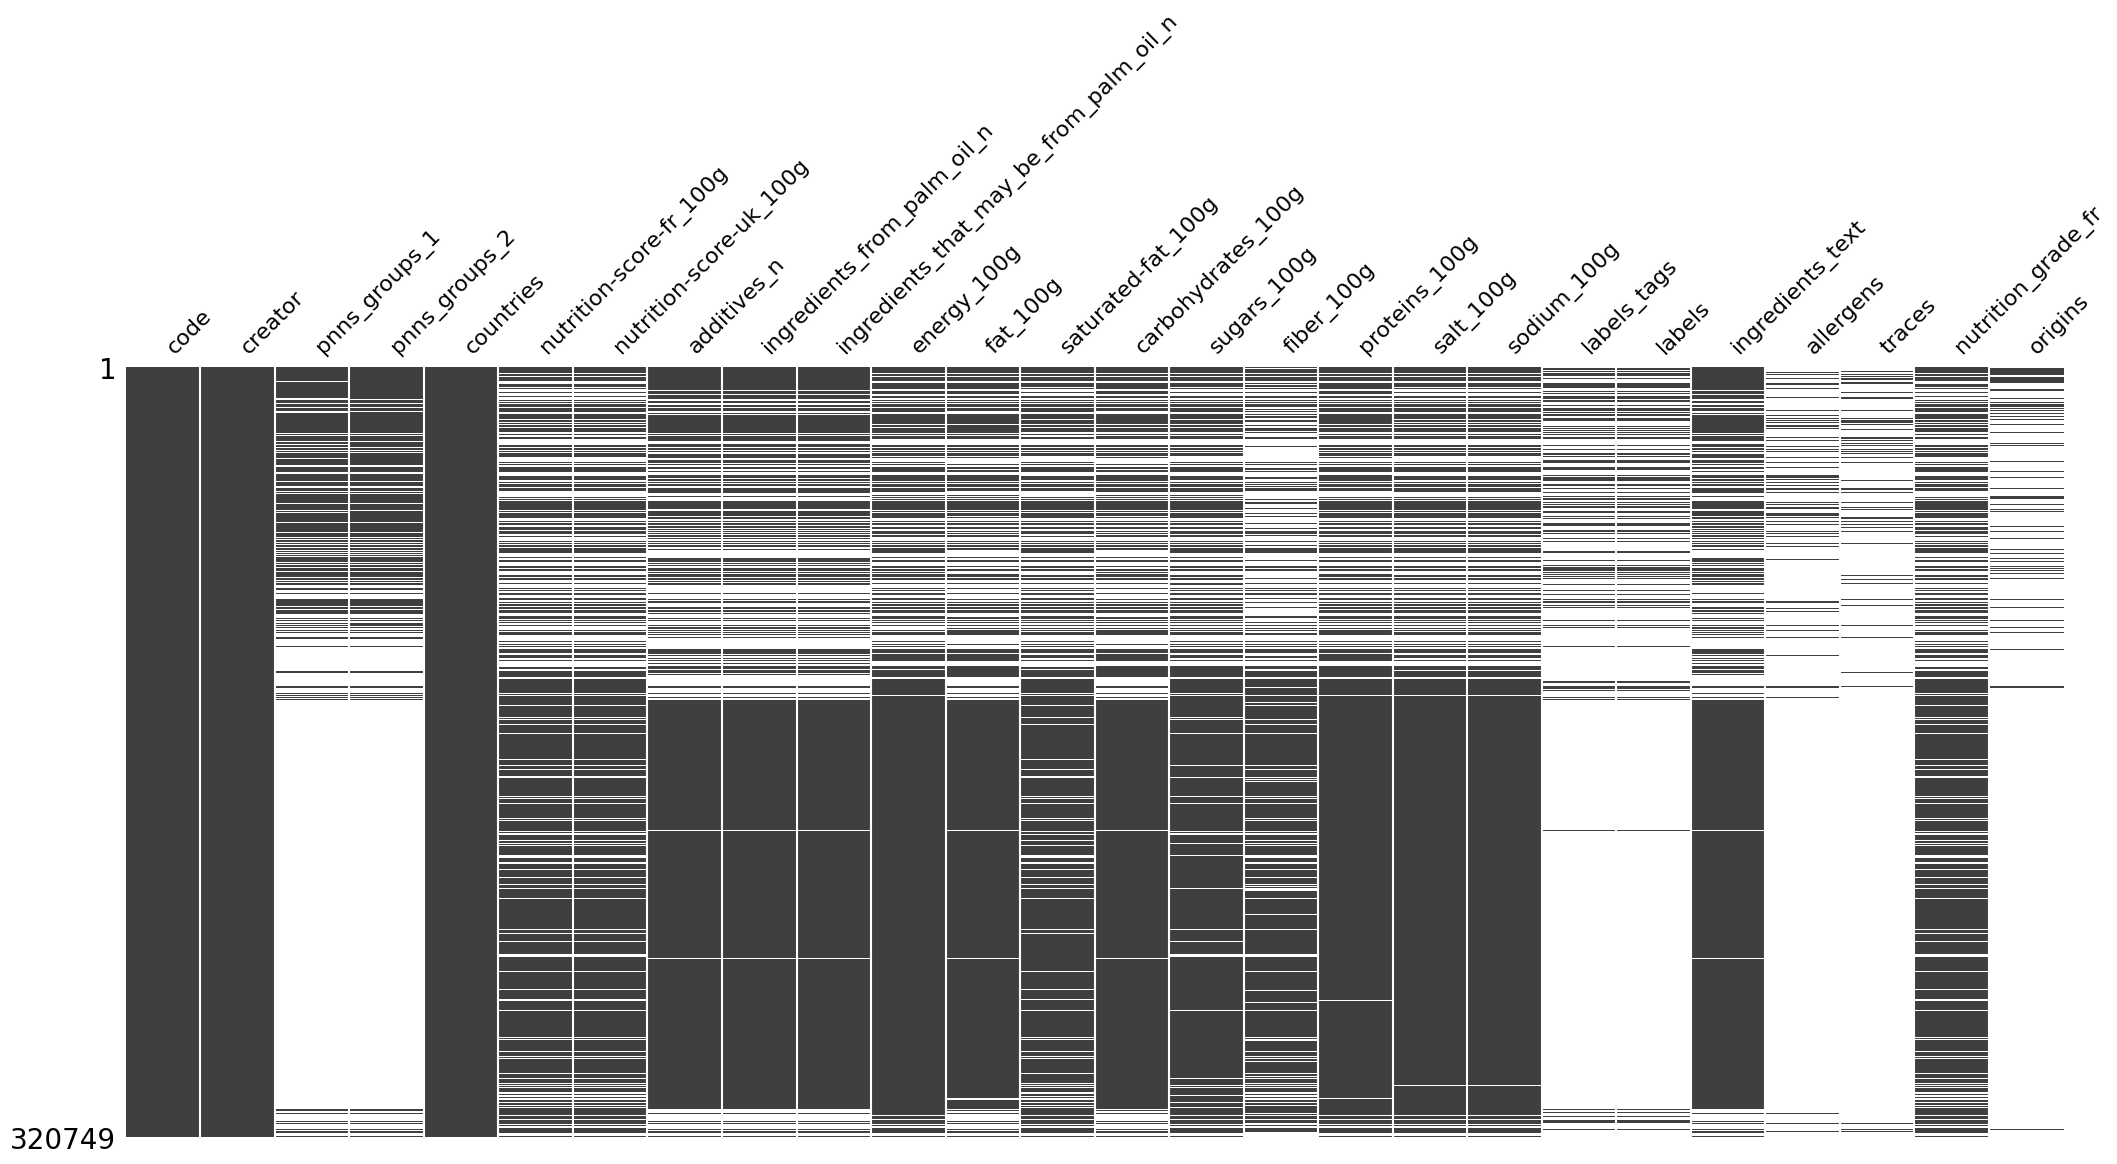

In [32]:
msno.matrix(df, sparkline=False)

<Axes: >

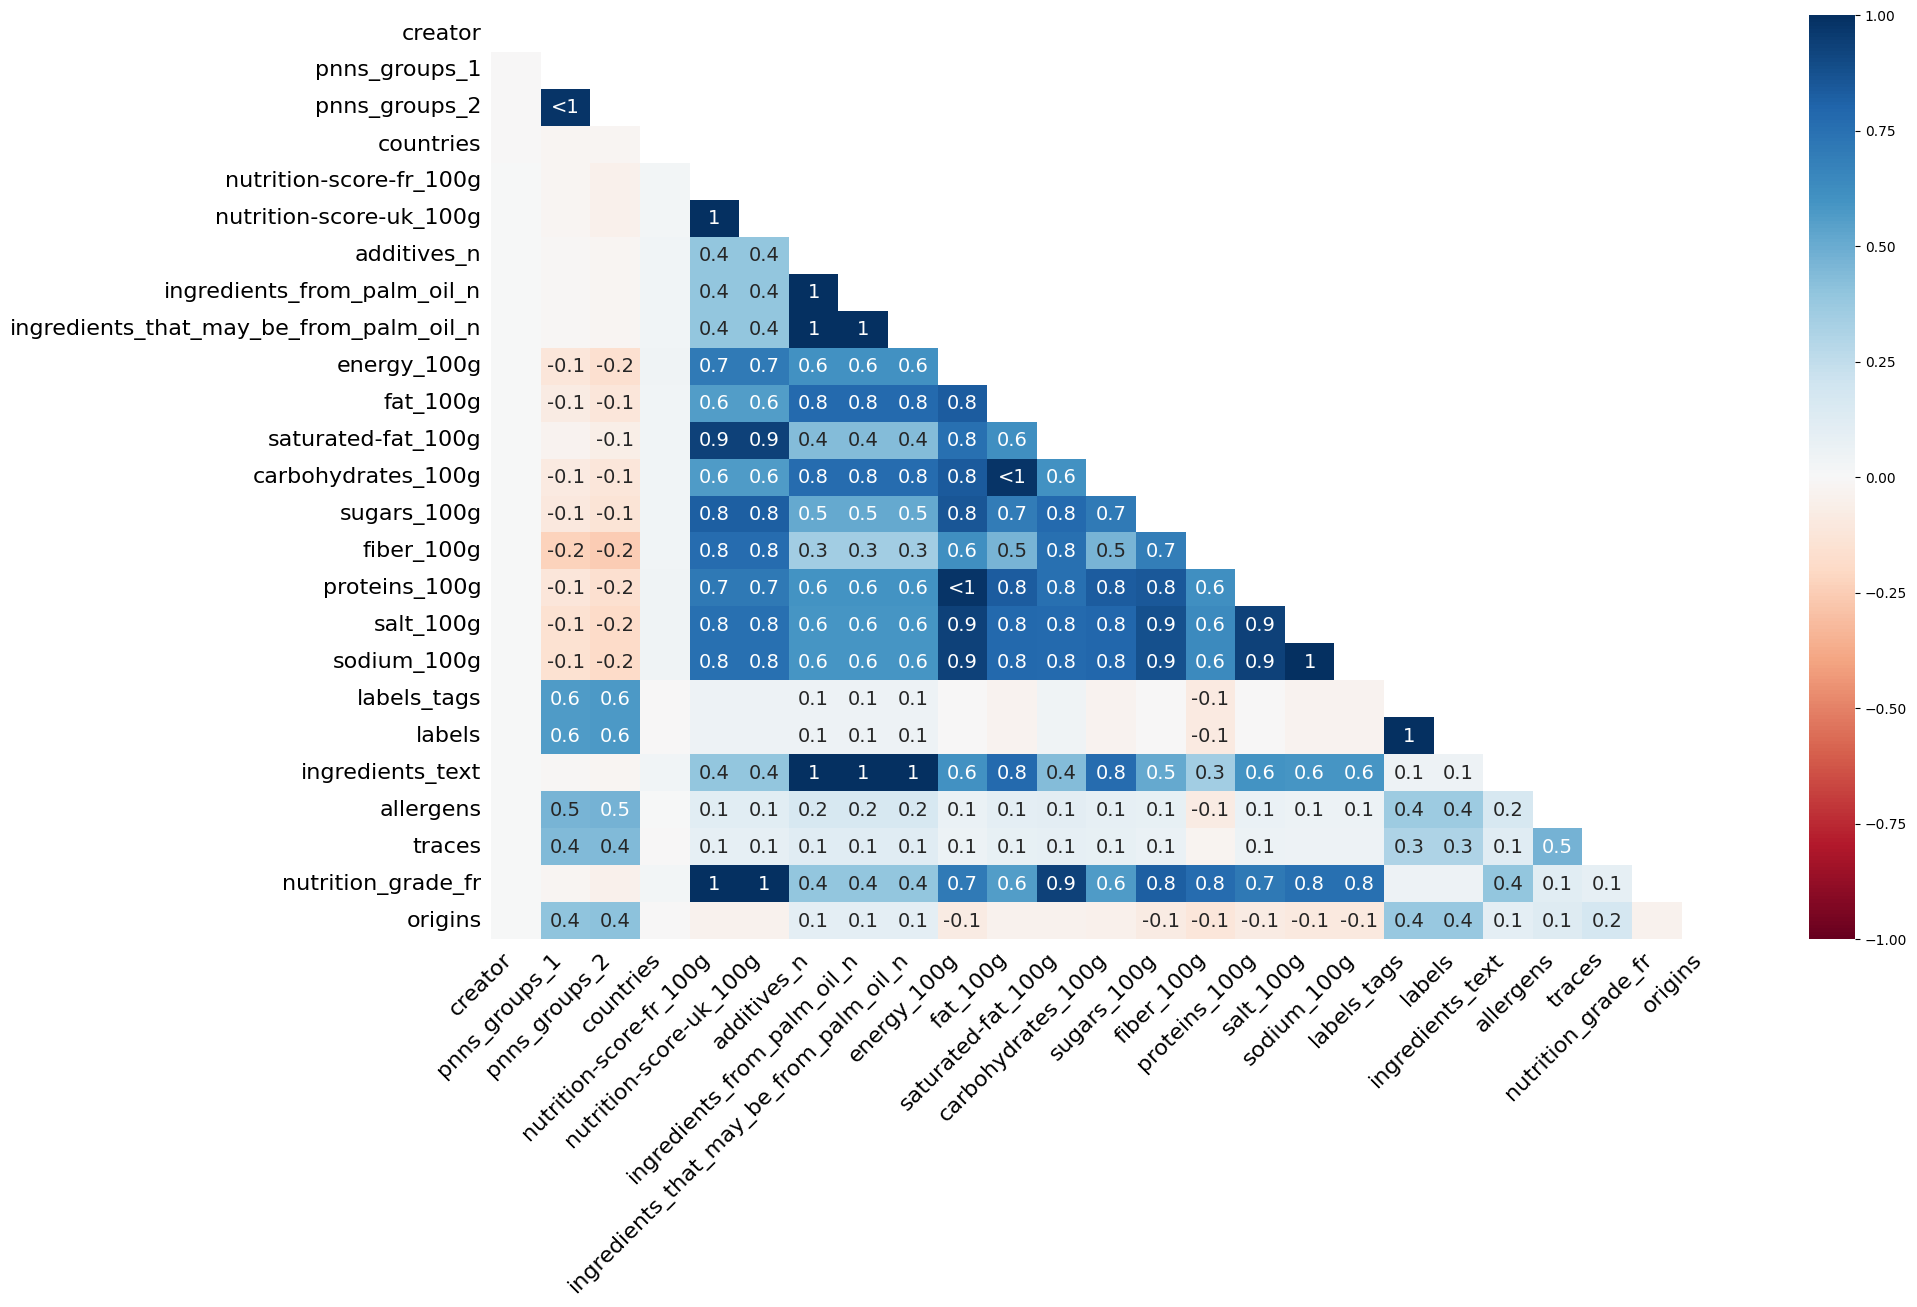

In [33]:
msno.heatmap(df)

# Question 11

Le Nutri-Score, utilisé en France, calcule un score global en soustrayant les points positifs (0-15 points basés sur les fruits, légumes, légumineuses, fibres et protéines) des points négatifs (0-40 points basés sur l'énergie, les sucres simples, les acides gras saturés et le sodium). Ce score détermine une lettre de A (vert foncé, -15 à -1) à E (rouge, 19 et plus). En revanche, le système britannique (Traffic Light System) utilise un système de feux tricolores séparés pour les graisses, graisses saturées, sucres et sel, où chaque nutriment reçoit une couleur (vert pour faible, orange pour moyen, rouge pour élevé). Les principales différences résident dans le fait que le Nutri-Score fournit une évaluation globale unique et prend en compte les éléments nutritionnels positifs, tandis que le système britannique évalue séparément chaque nutriment et se concentre uniquement sur les nutriments à limiter. Bien que le calcul français soit plus complexe, il offre une évaluation plus complète, alors que le système britannique, plus simple à comprendre, s'avère moins nuancé dans son approche. CopyRetryClaude can make mistakes. Please double-check responses.

# Question 12

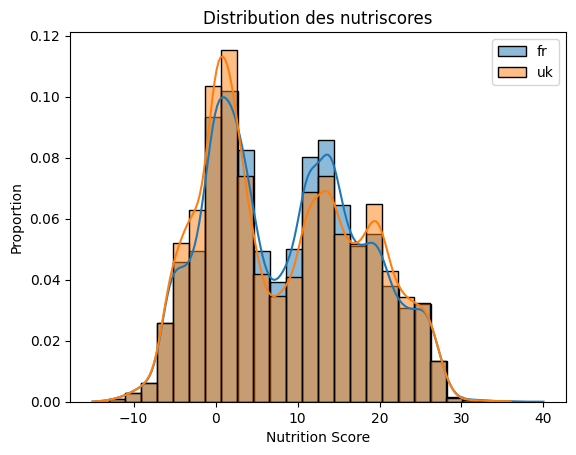

In [34]:
fig, ax = plt.subplots()

sns.histplot(df[df['creator'] != 'usda-ndb-import'], x='nutrition-score-fr_100g', stat='proportion', kde=True, alpha=0.5, binwidth=2, legend=True, label='fr')
sns.histplot(df[df['creator'] != 'usda-ndb-import'], x='nutrition-score-uk_100g',  stat='proportion', kde=True, alpha=0.5, binwidth=2, legend=True, label='uk')
plt.title('Distribution des nutriscores')
plt.xlabel('Nutrition Score')
plt.legend()
fig.savefig(figures_path + 'dist_nutriscore.png', bbox_inches = 'tight')

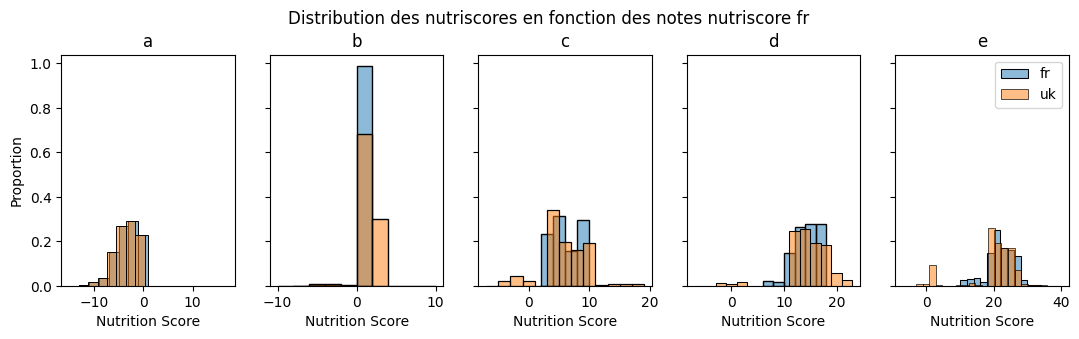

In [35]:
fig, ax = plt.subplots(1,5, sharey=True, figsize = (13,3))
grades = ['a', 'b', 'c', 'd', 'e']
fig.suptitle('Distribution des nutriscores en fonction des notes nutriscore fr', y=1.03)
for i in range(len(grades)):
    sns.histplot(ax=ax[i], data=df[(df['creator'] != 'usda-ndb-import') & (df['nutrition_grade_fr']==grades[i])], x='nutrition-score-fr_100g', stat='proportion', alpha=0.5, binwidth=2, label='fr')
    sns.histplot(ax=ax[i], data=df[(df['creator'] != 'usda-ndb-import') & (df['nutrition_grade_fr']==grades[i])], x='nutrition-score-uk_100g',  stat='proportion', alpha=0.5, binwidth=2, label='uk')
    ax[i].set_xlabel('Nutrition Score')
    ax[i].set_title(grades[i])
plt.legend()

fig.savefig(figures_path + 'dist_nutriscore_par_notes.png', bbox_inches = 'tight')

LEs distribution sont légèrement différentes pour les notes en dessous de *c* mais ça reste difficile de l'affirmer.

# Question 2
Regardons le nombre d'aliments dans chaque catégories

In [36]:
# Nettoyage de la colonnes pnns_groups_1 
df['pnns_groups_1'] = df['pnns_groups_1'].replace(to_replace=r'-', value=' ', regex=True)
df['pnns_groups_1'] = df['pnns_groups_1'].str.title()
df['pnns_groups_2'] = df['pnns_groups_2'].str.title()

In [37]:
df[['pnns_groups_1', 'pnns_groups_2']].groupby('pnns_groups_1', dropna=False).value_counts(dropna=False)

pnns_groups_1            pnns_groups_2                   
Beverages                Non-Sugared Beverages                 4302
                         Sweetened Beverages                   2170
                         Fruit Juices                          1924
                         Fruit Nectars                          376
                         Artificially Sweetened Beverages       261
Cereals And Potatoes     Cereals                               4118
                         Bread                                 1838
                         Breakfast Cereals                     1408
                         Legumes                                929
                         Potatoes                               165
Composite Foods          One-Dish Meals                        5546
                         Sandwich                               686
                         Pizza Pies And Quiche                  515
Fat And Sauces           Dressings And Sauces             

Tous les aliments n'ayant pas de pnns_groups 1 et 2 sont supprimés. Nous n'avous pas de moyen de savoir à quelle catégorie ils appartiennent. En revanche les aliments ayant une sous-catégorie pnns_groups_2 mais un pnns_groups_1 invalide peuvent être mis manuellement dans le bon pnns_groups_1

In [38]:
df.replace('Unknown', np.nan, inplace=True)
df.dropna(subset=['pnns_groups_1', 'nutrition_grade_fr'], inplace=True)

In [39]:
df.loc[df['pnns_groups_1'].isna() & (df['pnns_groups_2'] == 'Alcoholic Beverages'), 'pnns_groups_1'] = 'Beverages'
df.loc[df['pnns_groups_1'].isna() & (df['pnns_groups_2'] == 'Tripe Dishes'), 'pnns_groups_1'] = 'Fish Meat Eggs'

In [40]:
df[['pnns_groups_1', 'pnns_groups_2']].groupby('pnns_groups_1', dropna=False).value_counts(dropna=False)

pnns_groups_1            pnns_groups_2                   
Beverages                Non-Sugared Beverages               1876
                         Sweetened Beverages                 1712
                         Fruit Juices                        1592
                         Fruit Nectars                        290
                         Artificially Sweetened Beverages     227
Cereals And Potatoes     Cereals                             3315
                         Bread                               1483
                         Breakfast Cereals                   1266
                         Legumes                              661
                         Potatoes                              77
Composite Foods          One-Dish Meals                      4520
                         Sandwich                             625
                         Pizza Pies And Quiche                449
Fat And Sauces           Dressings And Sauces                2560
                  

# Question 3

Les produits les plus sains sont ceux ayant un nutriscore de **a**.

In [41]:
df[df['nutrition_grade_fr'] == 'a'][['pnns_groups_1', 'pnns_groups_2']].groupby(['pnns_groups_1', 'pnns_groups_2'], dropna=False).value_counts()

pnns_groups_1            pnns_groups_2                   
Beverages                Artificially Sweetened Beverages       3
                         Non-Sugared Beverages                205
                         Sweetened Beverages                   50
Cereals And Potatoes     Bread                                513
                         Breakfast Cereals                    276
                         Cereals                             2124
                         Legumes                              465
                         Potatoes                              59
Composite Foods          One-Dish Meals                      1238
                         Pizza Pies And Quiche                 10
                         Sandwich                              57
Fat And Sauces           Dressings And Sauces                  91
                         Fats                                   2
Fish Meat Eggs           Eggs                                 109
                  

On remarque que chaque catégories contient de aliments sains. En revanche parmis les aliments sains on ne retrouve pas de jus de fruits, nectares et boissons alcoliques.

# Question 4

Si l'on suppose que le code est propre à chaque produits alors nous n'avous pas de doublons dans notre jeu de données. En revanche certaines colonnes sont fortement corrélées. C'est le case des colonnes labels et labels_tags mais aussi des colonnes salt_100g et sodium_100g ou encore les colonnes nutrition-score-fr_100g et nutrition-score-uk_100g

In [42]:
df.drop(columns=['sodium_100g'], inplace=True)

# Question 5
Regardons le nombre d'allengènes par produits. Les données manquantes de certaines colonnes peuvent être remplacées par des zéro ou des chaines vides.

In [43]:
df.fillna({'ingredients_from_palm_oil_n': 0.0, 'ingredients_that_may_be_from_palm_oil_n': 0.0}, inplace=True)
df.fillna({'additives_n' : 0.0, 'labels' :'', 'labels_tags' : '', 'allergens' : '', 'traces' : '', 'ingredients_text' : ''}, inplace=True)
df.dropna(subset=['nutrition_grade_fr'], inplace=True)
df.reset_index(inplace=True, drop=True)
df['allergens_n'] = df['allergens'].str.lower().str.split(',').apply(lambda x : len(set(x)))

Calcul du nombre moyen d'allergènes.

In [44]:
df_count_allergens = df[['pnns_groups_1', 'pnns_groups_2', 'allergens_n']].groupby(['pnns_groups_1', 'pnns_groups_2']).mean()

df_count_allergens.reset_index(inplace=True)
df_allergens_plot = df_count_allergens.sort_values(by=['pnns_groups_1', 'allergens_n'], ascending=True).groupby(['pnns_groups_1', 'pnns_groups_2', 'allergens_n'], sort=False).mean().reset_index()

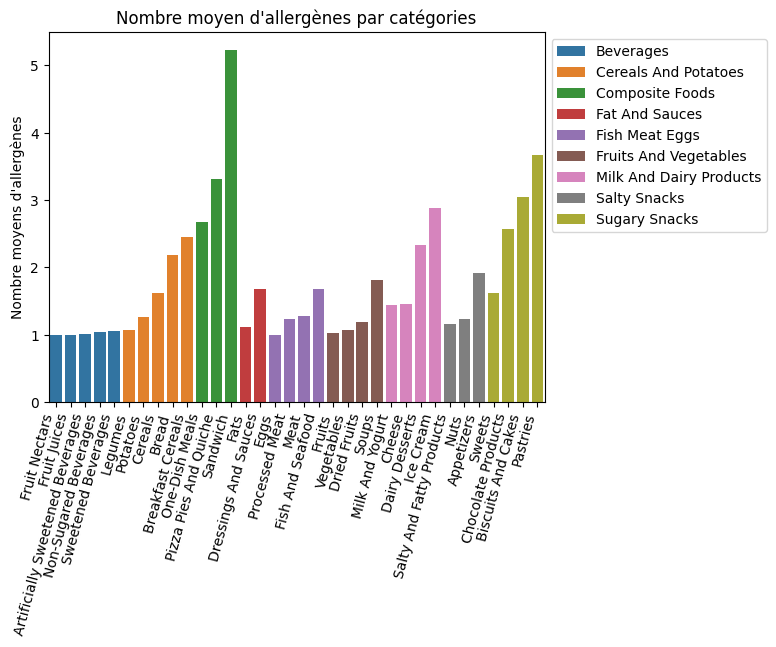

In [45]:
fig, ax = plt.subplots()
sns.barplot(df_allergens_plot, x='pnns_groups_2', y='allergens_n', hue='pnns_groups_1')
ax.legend(bbox_to_anchor=(1, 1))
plt.title("Nombre moyen d'allergènes par catégories")
plt.xlabel('')
plt.ylabel("Nombre moyens d'allergènes")
plt.xticks(rotation=75, ha='right')
fig.savefig(figures_path + 'allergens.png', bbox_inches = 'tight')

Les aliments contenant le plus d'allergènes sont les aliments composés et les snacks salés.

In [46]:
df_count_additives = df[['pnns_groups_1', 'pnns_groups_2', 'additives_n']].groupby(['pnns_groups_1', 'pnns_groups_2']).mean().fillna(0)
df_count_additives.reset_index(inplace=True)
df_additives_plot = df_count_additives.sort_values(by=['pnns_groups_1', 'additives_n'], ascending=True).groupby(['pnns_groups_1', 'pnns_groups_2', 'additives_n'], sort=False).mean().reset_index()

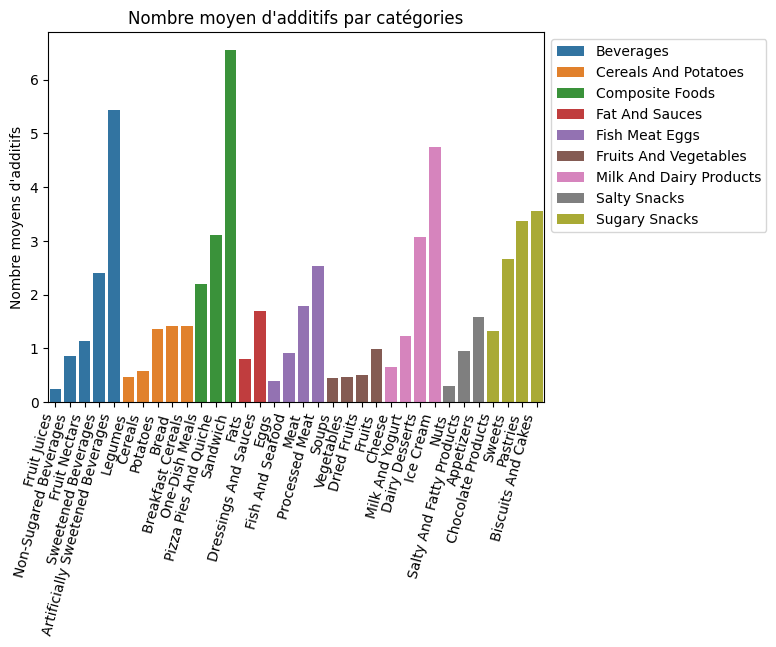

In [47]:
fig, ax = plt.subplots()
sns.barplot(df_additives_plot, x='pnns_groups_2', y='additives_n', hue='pnns_groups_1')
ax.legend(bbox_to_anchor=(1, 1))
plt.title("Nombre moyen d'additifs par catégories")
plt.xlabel('')
plt.ylabel("Nombre moyens d'additifs")
plt.xticks(rotation=75, ha='right')
fig.savefig(figures_path + 'additifs.png', bbox_inches = 'tight')

Les aliments contenant le plus d'additifs sont les aliments composés les snakcs salés les produits laitiers. Il semble y avoir une faible corrélation entre la quantité d'additifs et la quantité d'allergènes.

In [48]:
df[['allergens_n', 'additives_n']].corr()

,allergens_n,additives_n
allergens_n,1.00000,0.32435
additives_n,0.32435,1.00000


# Question 6

Pour pouvoir calculer les corrélations proprement, nous devons calculer les valeurs manquantes. Pour cela nous choisissons d'utilise une imputation par KNN.

In [49]:
columns_to_keep = ['pnns_groups_1', 'pnns_groups_2', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',  'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g', 'nutrition_grade_fr']

df_corr = df[columns_to_keep].copy()

<Axes: >

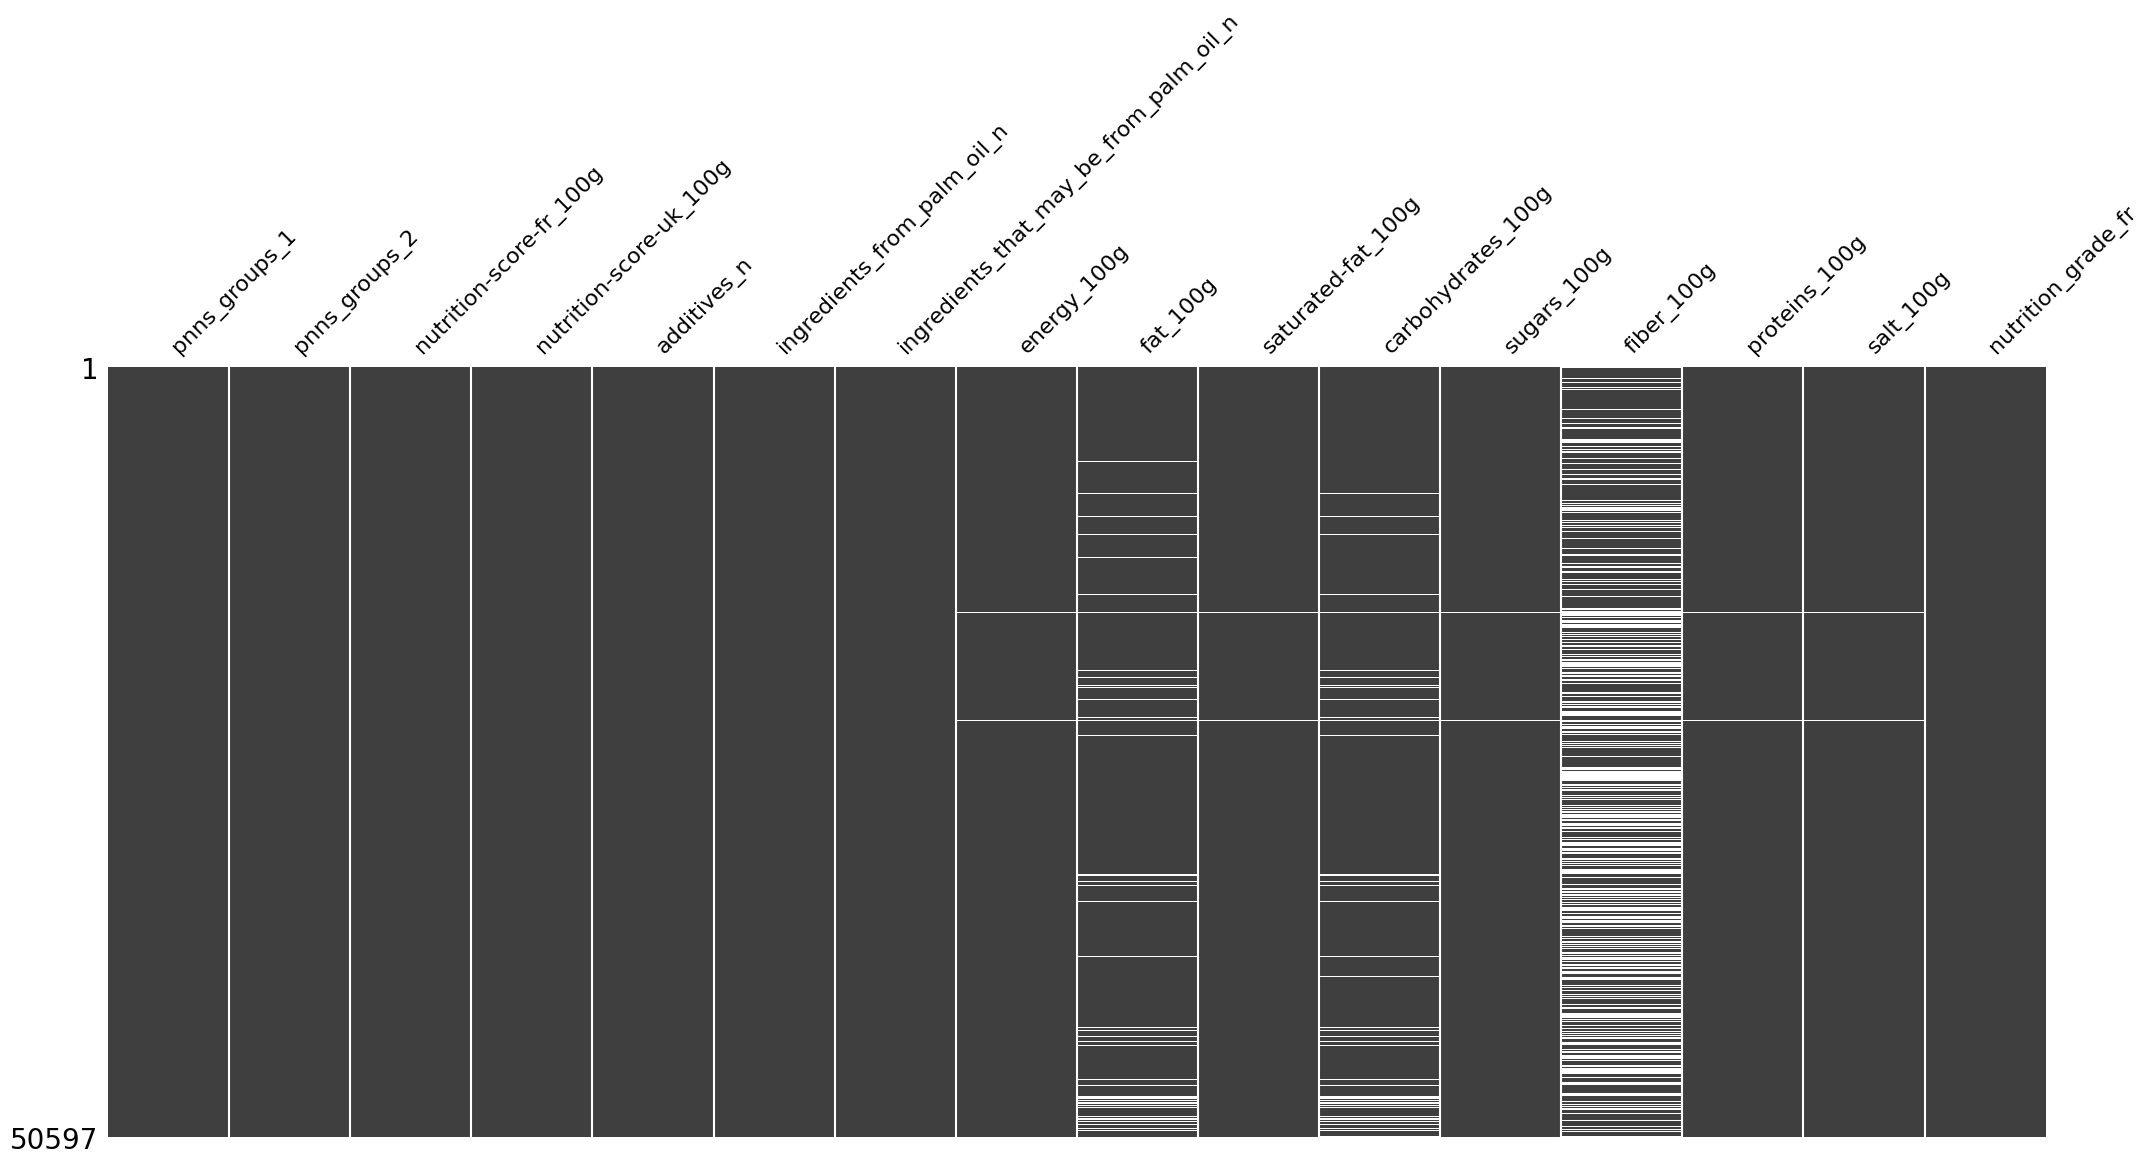

In [50]:
msno.matrix(df_corr, sparkline=False)

In [51]:
df_info = get_dataframe_info(df_corr, ascending=False, percentage=True)
df_info

,Column,Dtype,Non-null Count (%)
0,pnns_groups_1,object,100.000000
1,pnns_groups_2,object,100.000000
2,nutrition-score-fr_100g,float64,100.000000
3,nutrition-score-uk_100g,float64,100.000000
4,additives_n,float64,100.000000
5,ingredients_from_palm_oil_n,float64,100.000000
6,ingredients_that_may_be_from_palm_oil_n,float64,100.000000
15,nutrition_grade_fr,object,100.000000
7,energy_100g,float64,99.776667
9,saturated-fat_100g,float64,99.776667


In [52]:
# Regardons les valeus abberantes
df_corr.describe()

,nutrition-score-fr_100g,nutrition-score-uk_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,50597.000000,50597.000000,50597.000000,50597.000000,50597.000000,50484.000000,48100.000000,50484.000000,48058.00000,50484.00000,32162.00000,50484.000000,50484.000000
mean,8.336245,7.875526,1.718145,0.057316,0.128644,1103.175235,13.542828,5.419138,27.51655,12.97590,2.69043,7.491591,0.863900
std,9.185674,9.672832,2.477216,0.235824,0.426549,812.566379,17.492693,8.497645,27.27586,18.50995,3.84341,7.269795,2.573743
min,-15.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.10000,0.00000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,384.000000,1.100000,0.200000,4.10000,1.00000,0.30000,1.600000,0.052832
50%,8.000000,6.000000,1.000000,0.000000,0.000000,1006.000000,6.400000,1.800000,14.00000,4.10000,1.60000,5.900000,0.500000
75%,15.000000,16.000000,3.000000,0.000000,0.000000,1665.000000,22.000000,7.500000,53.00000,16.00000,3.50000,10.500000,1.200000
max,40.000000,35.000000,31.000000,2.000000,5.000000,22000.000000,380.000000,210.000000,190.00000,134.00000,86.20000,86.000000,297.600000


Les distributions sont assymétriques. Les moyennes et les médiannessont différentes. On remarque aussi certains valeurs aberrantes. La colonnes sugars_100g contient des données négatives et certaines valeurs sont supérieures à 100g.

In [53]:
df_corr.loc[:,'sugars_100g'] = df_corr['sugars_100g'].abs()

In [54]:
import sklearn
from sklearn.impute import KNNImputer
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
#sklearn.set_config(transform_output="pandas")

In [55]:
imputation_cols = ['pnns_groups_1', 'pnns_groups_2', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'additives_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g','proteins_100g', 'salt_100g']
df_X = df_corr[imputation_cols].copy()

In [56]:
df_pnns1 = df_X['pnns_groups_1'].copy()
df_pnns2 = df_X['pnns_groups_2'].copy()
# Encode les categories pnns en entier
label_encoder = preprocessing.LabelEncoder()
df_X.loc[:,'pnns_groups_1_int'] = label_encoder.fit_transform(df_X['pnns_groups_1'].values)
df_X.loc[:,'pnns_groups_2_int'] = label_encoder.fit_transform(df_X['pnns_groups_2'].values)

In [57]:
# Obligatoire pour convertir pnns_groups_1 et pnns_groups_2 en int
imputation_cols = ['pnns_groups_1_int', 'pnns_groups_2_int', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'additives_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g','proteins_100g', 'salt_100g']

df_Xs=df_X[imputation_cols].reset_index(drop=True).copy() 
get_dataframe_info(df_Xs, ascending=False, percentage=True)

,Column,Dtype,Non-null Count (%)
0,pnns_groups_1_int,int64,100.000000
1,pnns_groups_2_int,int64,100.000000
2,nutrition-score-fr_100g,float64,100.000000
3,nutrition-score-uk_100g,float64,100.000000
4,additives_n,float64,100.000000
5,energy_100g,float64,99.776667
7,saturated-fat_100g,float64,99.776667
9,sugars_100g,float64,99.776667
11,salt_100g,float64,99.776667
10,proteins_100g,float64,99.776667


In [58]:
# Avant d'utiliser l'imputation par KNN nous devons normaliser nos données
df_Xs = df_Xs.to_numpy()
scalerX = StandardScaler().fit(df_Xs)
df_Xs   = scalerX.transform(df_Xs)

In [59]:
# Nous pouvons faire l'imputation 
imputer = KNNImputer(missing_values=np.nan, n_neighbors=1)
df_Xs = imputer.fit_transform(df_Xs)
#get_dataframe_info(df_Xs)

Nous avons comblé toutes les valeurs manquantes

In [60]:
# Inverse la normalisation pour reconstruire nos données
df_Xs = pd.DataFrame(scalerX.inverse_transform(df_Xs))

imputation_cols = ['pnns_groups_1', 'pnns_groups_2', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'additives_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g','proteins_100g', 'salt_100g']
df_Xs.columns =imputation_cols
# Inverse l'endodage des catégorie 
df_Xs['pnns_groups_1'] = df_pnns1
df_Xs['pnns_groups_2'] = df_pnns2



In [61]:
df_Xs.head()

,pnns_groups_1,pnns_groups_2,nutrition-score-fr_100g,nutrition-score-uk_100g,additives_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g
0,Sugary Snacks,Sweets,28.0,28.0,2.0,1717.0,10.9,7.0,73.5,49.3,3.0,1.7000
1,Salty Snacks,Appetizers,9.0,9.0,1.0,1898.0,15.5,1.3,68.0,2.0,8.5,1.7526
2,Sugary Snacks,Biscuits And Cakes,13.0,13.0,3.0,1637.0,3.2,0.9,81.0,55.3,7.6,0.3810
3,Sugary Snacks,Biscuits And Cakes,19.0,19.0,2.0,2040.0,25.0,14.0,56.0,33.0,7.0,0.3810
4,Sugary Snacks,Chocolate Products,23.0,23.0,1.0,2320.0,35.5,15.0,48.5,47.0,8.1,0.3500


In [62]:
df_Xs.describe()

,nutrition-score-fr_100g,nutrition-score-uk_100g,additives_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g
count,50597.000000,5.059700e+04,50597.000000,50597.000000,50597.000000,50597.000000,50597.000000,50597.000000,50597.000000,50597.000000
mean,8.336245,7.875526e+00,1.718145,1101.856772,13.445892,5.409202,27.338791,12.958242,7.486119,0.862787
std,9.185674,9.672832e+00,2.477216,812.505329,17.563518,8.490935,27.294954,18.494072,7.267530,2.571044
min,-15.000000,-1.500000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,-8.881784e-16,0.000000,383.000000,1.000000,0.200000,4.100000,1.000000,1.600000,0.053000
50%,8.000000,6.000000e+00,1.000000,1004.000000,6.100000,1.800000,13.800000,4.100000,5.900000,0.500000
75%,15.000000,1.600000e+01,3.000000,1664.000000,22.000000,7.500000,53.000000,16.000000,10.500000,1.200000
max,40.000000,3.500000e+01,31.000000,22000.000000,380.000000,210.000000,190.000000,134.000000,86.000000,297.600000


L'imputation KNN n'a pas modifié la distributions des valeurs.

<Axes: >

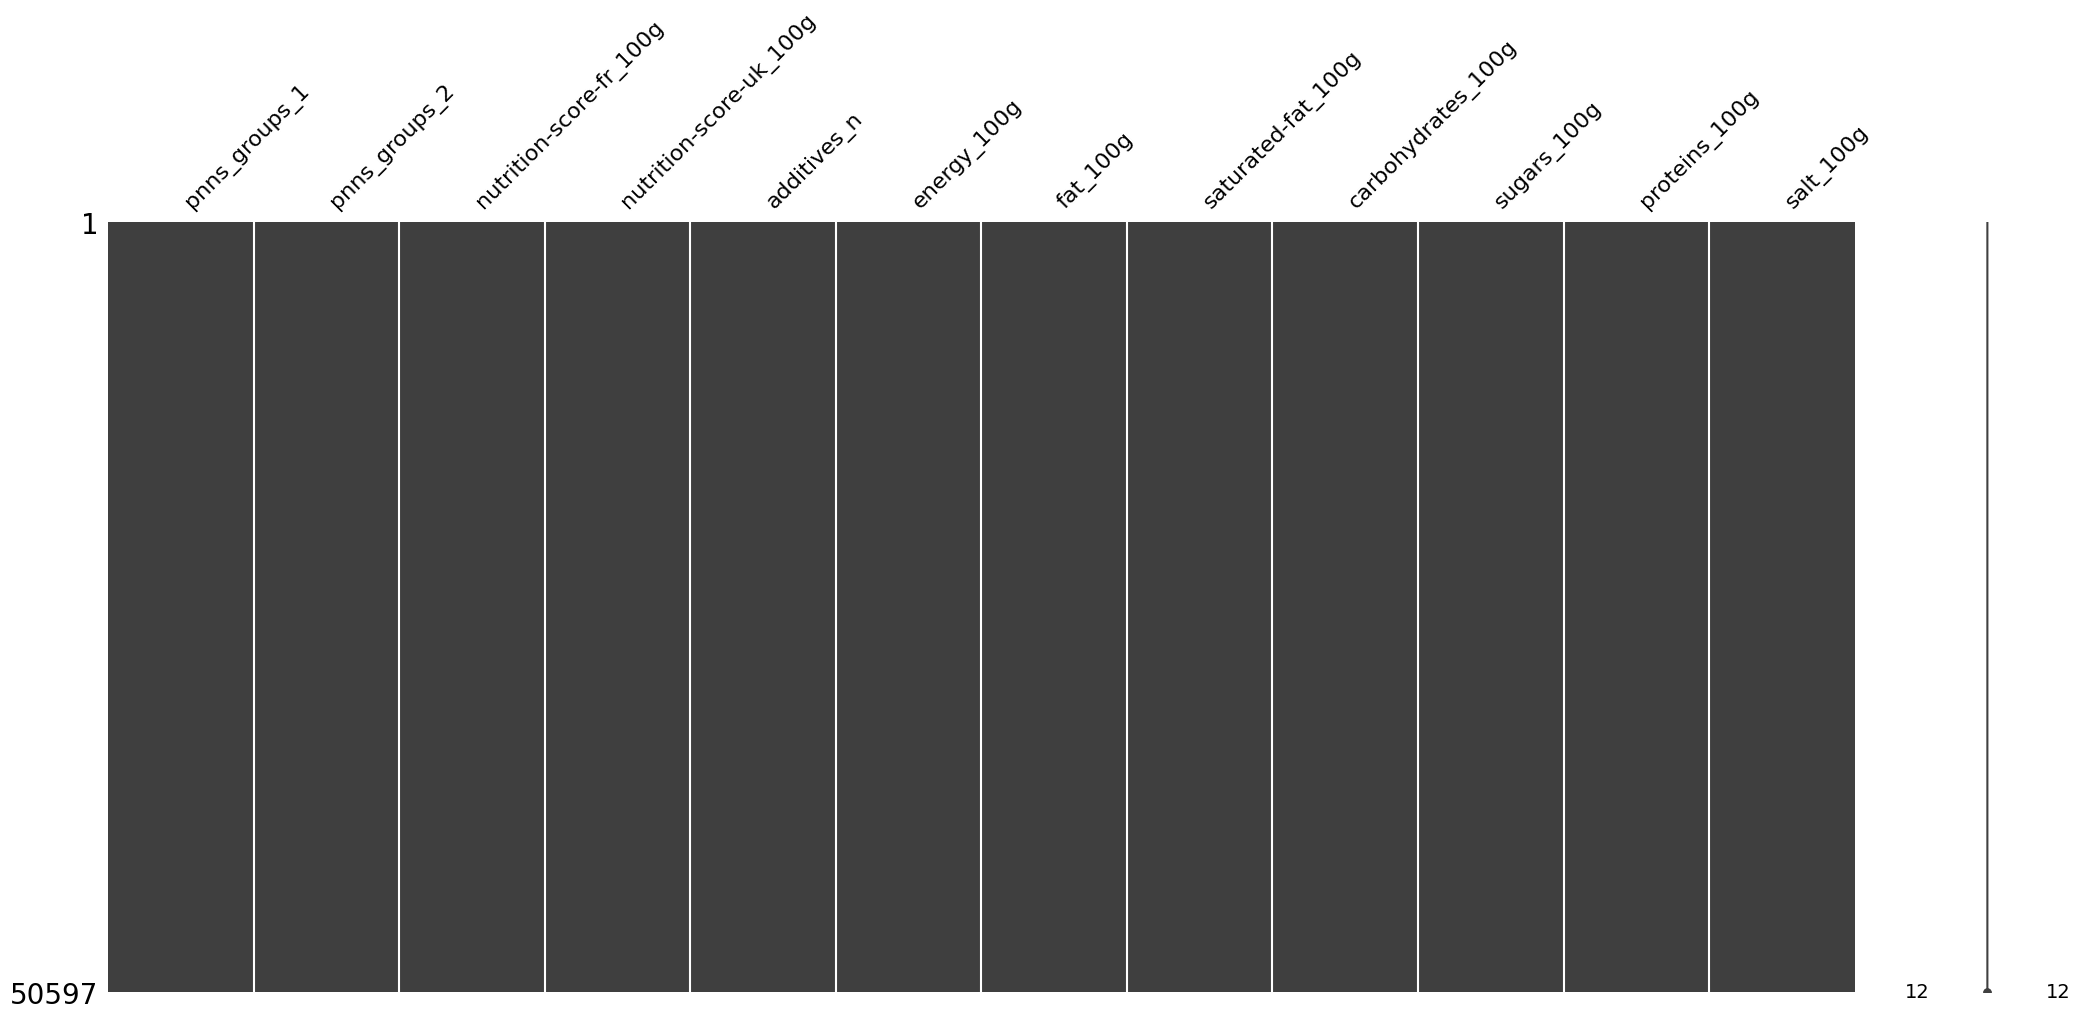

In [63]:
msno.matrix(df_Xs)

Calcule des corrélations

<Axes: >

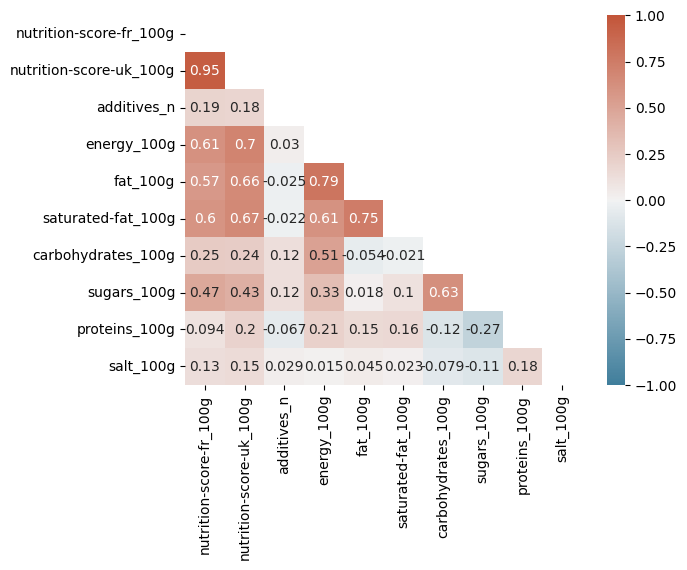

In [64]:
corr= df_X.select_dtypes(include='float').corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, vmin=-1, vmax=1)


La corrélation entre le sucre et le nutriscore est de 0.4. Il n'y a qu'une faible corrélation entre la présence d'additifs et le nutriscore.

# Question 7

In [65]:
df[(df['ingredients_from_palm_oil_n'] > 0) | (df['ingredients_that_may_be_from_palm_oil_n'] > 0)][['pnns_groups_1', 'pnns_groups_2']].groupby('pnns_groups_1').value_counts()

pnns_groups_1            pnns_groups_2                   
Beverages                Sweetened Beverages                  120
                         Non-Sugared Beverages                 48
                         Artificially Sweetened Beverages      21
                         Fruit Nectars                         11
                         Fruit Juices                           8
Cereals And Potatoes     Bread                                494
                         Breakfast Cereals                    330
                         Cereals                              176
                         Legumes                               18
                         Potatoes                              14
Composite Foods          One-Dish Meals                       590
                         Sandwich                             355
                         Pizza Pies And Quiche                128
Fat And Sauces           Dressings And Sauces                 211
                  

In [66]:
# Proportion d'aliments contentant de l'huile de palme
df[(df['ingredients_from_palm_oil_n'] > 0) | (df['ingredients_that_may_be_from_palm_oil_n'] > 0)].shape[0]/df.shape[0]*100

13.805166314208353

# Question 9

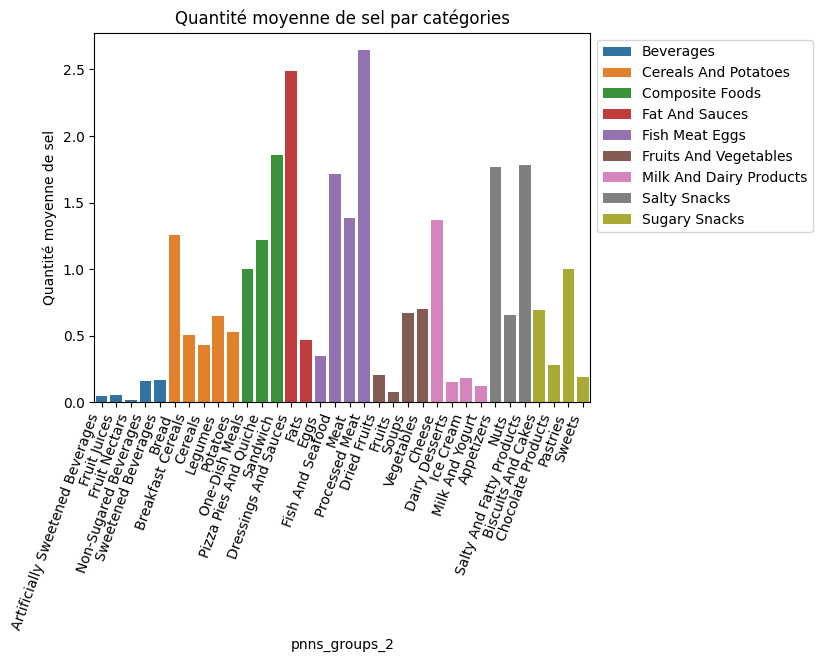

In [67]:
df_salt_plot = df[['pnns_groups_1', 'pnns_groups_2', 'salt_100g']] .groupby(['pnns_groups_1', 'pnns_groups_2']).mean().reset_index()

fig, ax = plt.subplots()

sns.barplot(df_salt_plot, x='pnns_groups_2', y='salt_100g', hue='pnns_groups_1')
ax.legend(bbox_to_anchor=(1, 1))
plt.title('Quantité moyenne de sel par catégories')
plt.ylabel('Quantité moyenne de sel')
plt.xticks(rotation=70, ha='right')
fig.savefig(figures_path + 'sel.png', bbox_inches = 'tight')

Les produits qui contiennent le plus de sauces sont les plats à base de viandes transformées, les sauces et les snacks salés.